<a href="https://colab.research.google.com/github/Kavyanadiu/FMML-LABS/blob/main/Module_7_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Module 7 Project: Movie Recommendation Engine

`Module Coordinator: Ganesh Chandan`

In this module, we will try to create a Movie Recommendation System using different unsupervised learning techniques.

In [1]:
# dataset download

# !wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2025-02-18 16:00:02--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  2.48MB/s    in 0.4s    

2025-02-18 16:00:02 (2.48 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


## Clustering based recommendation

In [2]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
# Import the Movies dataset
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Import the ratings dataset
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# Print the number of records and the total number of movies
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


### Romance versus Science Fiction

We will start by considering a subset of users and discovering what are their favourite genre. We will do this by defining a function that will calculate each user’s average rating for all science fiction and romance movies.

In [6]:
# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)

        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)

    genre_ratings.columns = column_names
    return genre_ratings# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50


In order to have a more delimited subset of people to study, we are going to bias our grouping to only get ratings from those users that like either romance or science fiction movies.

In [7]:
# Function to get the biased dataset
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

# Bias the dataset
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  162


,index,avg_romance_rating,avg_scifi_rating
0,3,0.50,4.20
1,4,3.38,2.83
2,5,3.09,2.50
3,7,2.65,3.15
4,9,3.17,3.00


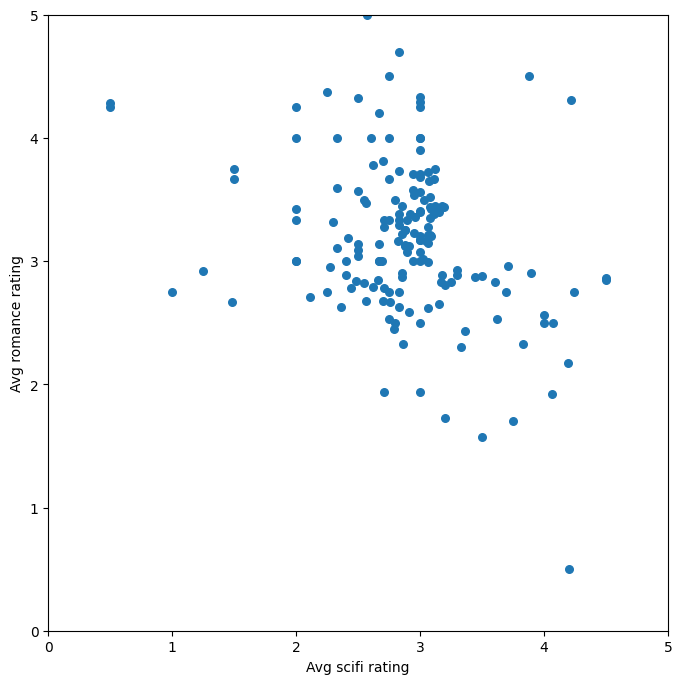

In [8]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)

# Plot the scatterplot
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

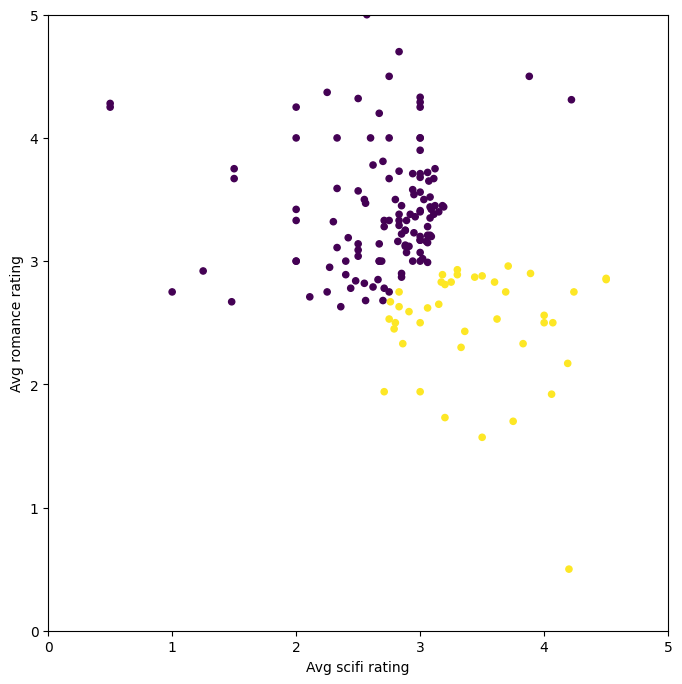

In [9]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values

# Import KMeans
from sklearn.cluster import KMeans

# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)

# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)

# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)

# Plot
draw_clusters(biased_dataset, predictions)

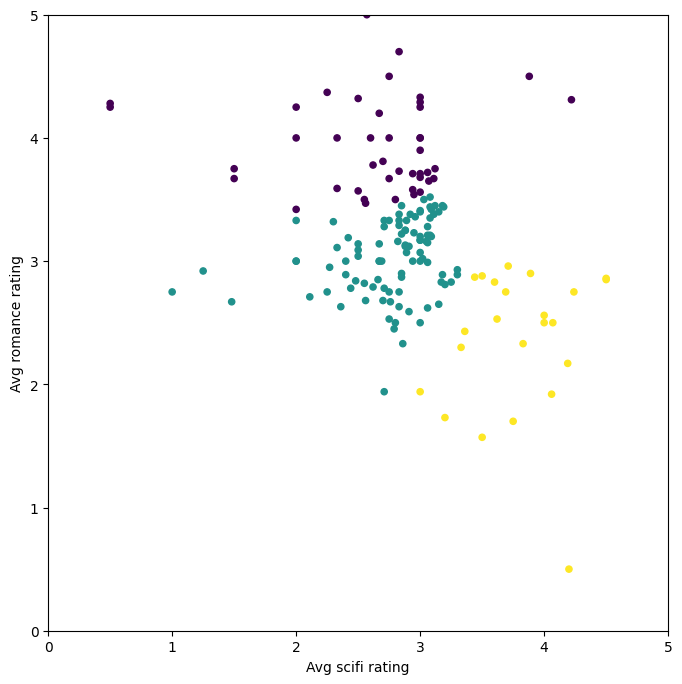

In [10]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)
# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_2)

It is evident now that the science-fiction rating has started to come into play:

    People who like sci-fi and romance modeately belong to the green group.
    People who like scifi but not romance belong to the yello group.
    People who like romance but not sci-fi belong to the purple group.

Finding optimal clusters using silhouette score

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (157) found smaller than n_clusters (162). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


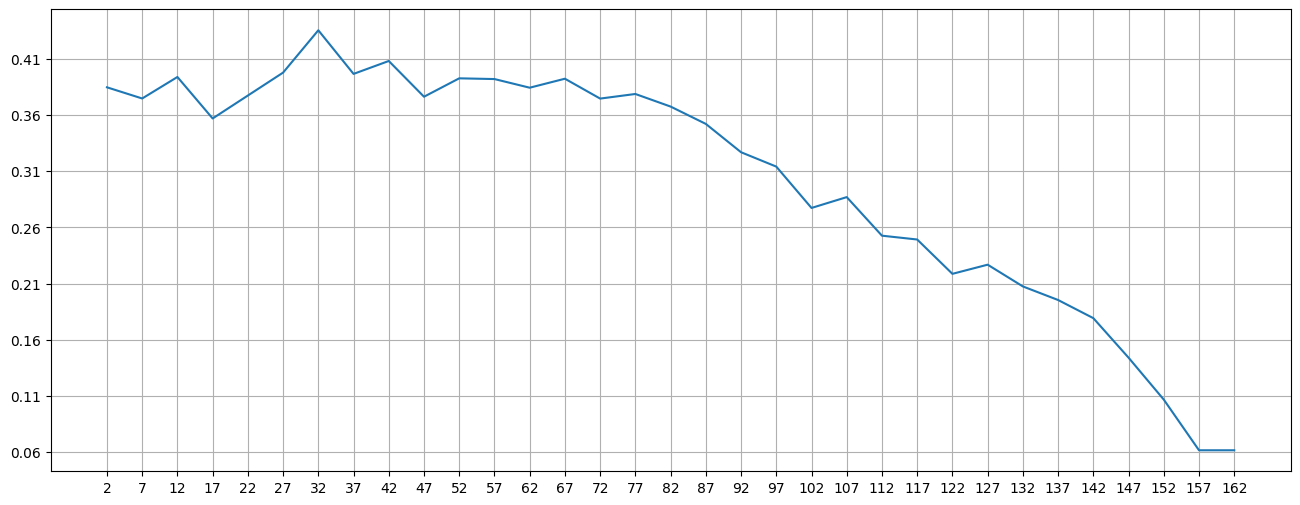

In [11]:
# Selecting our dataset to study
df = biased_dataset[['avg_scifi_rating','avg_romance_rating']]

# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)

# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]

# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

We will chose the K = 7 as it is the one that yields the best score and will be easier to visualize.



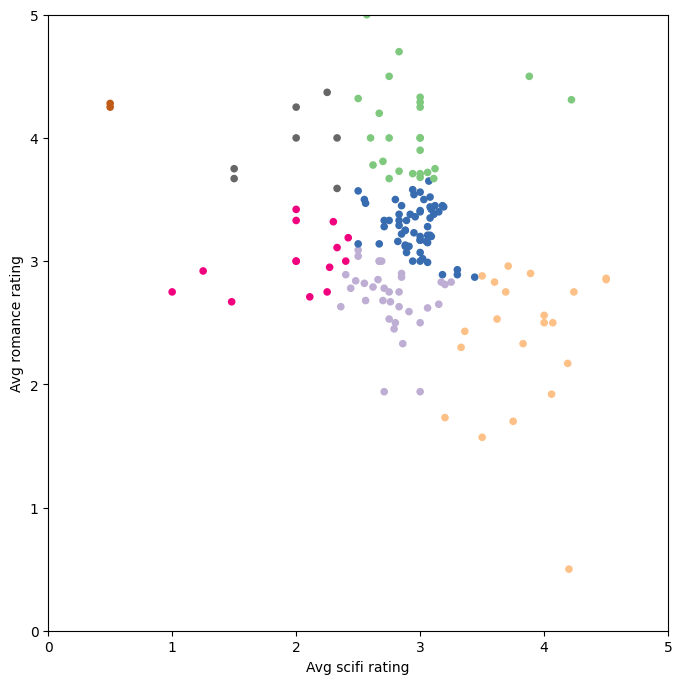

In [12]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

Up to now, we have only analyzed romance and science-fiction movies. Let us see what happens when adding other genre to our analysis by adding Action movies.

In [13]:
# Select our biased dataset and add action genre
biased_dataset_3_genres = get_genre_ratings(ratings, movies, ['Romance','Sci-Fi', 'Action'],
['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])
# Drop null values
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()
# Print the number of records and the head of our dataset
print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  161


,index,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,3,0.50,4.20,3.57
1,4,3.38,2.83,3.32
2,5,3.09,2.50,3.11
3,7,2.65,3.15,3.26
4,9,3.17,3.00,3.12


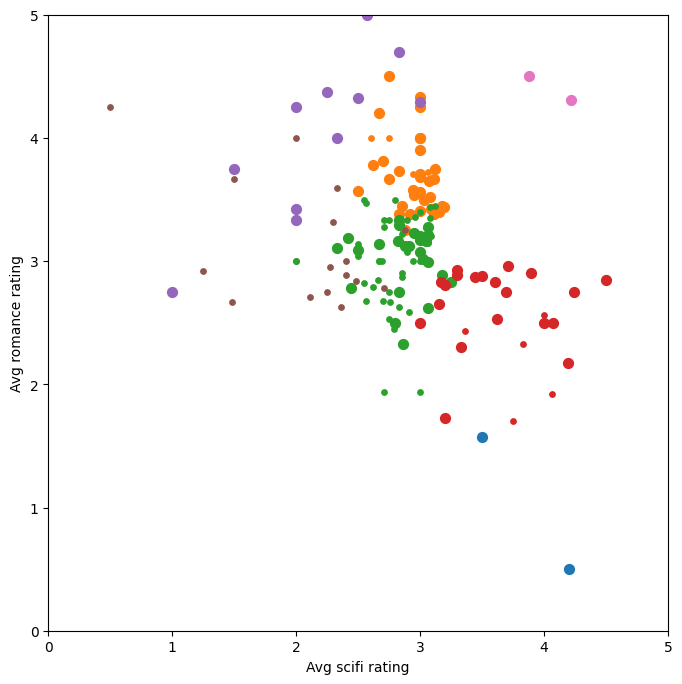

In [14]:
# Turn dataset into a list
X_with_action = biased_dataset_3_genres[['avg_scifi_rating','avg_romance_rating','avg_action_rating']].values# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(X_with_action)
# Define 3d plotting function
def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3:
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_scifi_rating'],
                        point['avg_romance_rating'],
                        s=size,
                        color=color)# Plot
draw_clusters_3d(biased_dataset_3_genres, predictions_5)

The size of the dots represent the ratings of the action movies.

# Exercise 1

## Instead of choosing a n_clusters as 7, play around with different k
## Find the optimal no of clusters with 3 genre_ratings data we just created using silhouette score method

In [15]:
# CODE

### Taking users into consideration

Once we have seen and understood how the K-Means algorithm group the users by their movie genre preferences, we are going to take a bigger picture of the dataset and explore how users rate individual movies.

To do so, we will subset the dataset by ‘userid’ vs ‘user rating’ as follows.

In [16]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

# Print he number of dimensions and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
 #Define Function to get the most rated movies
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    # Instead of append, use concat to add the count row
    user_movie_ratings = pd.concat([user_movie_ratings, pd.DataFrame([user_movie_ratings.count()])], ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

# Define function to get the user who rate a movie the most
def get_users_who_rate_the_most(most_rated_movies, n_users):
    most_rated_movies['num_ratings'] = - most_rated_movies.isnull().sum(axis=1)
    most_rated_movies = most_rated_movies.sort_values(by=['num_ratings'], ascending=False)
    most_rated_movies = most_rated_movies.iloc[:n_users, :]
    most_rated_movies = most_rated_movies.drop('num_ratings', axis=1)
    return most_rated_movies

# Define the sorting by rating function
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

# choose the number of movies and users and sort
n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

# Print the result
# print(most_rated_movies_users_selection)
print('dataset dimensions: ', most_rated_movies_users_selection.shape)
print(most_rated_movies_users_selection.head())

dataset dimensions:  (18, 30)
title  Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
479                    5.0                               5.0   
473                    3.0                               5.0   
67                     3.5                               3.0   
413                    5.0                               5.0   
589                    5.0                               4.5   

title  Pulp Fiction (1994)  Silence of the Lambs, The (1991)  \
479                    4.0                               4.5   
473                    4.0                               4.5   
67                     2.0                               3.5   
413                    5.0                               4.0   
589                    4.5                               3.5   

title  Matrix, The (1999)  Star Wars: Episode IV - A New Hope (1977)  \
479                   5.0                                        4.5   
473                   4.5                               

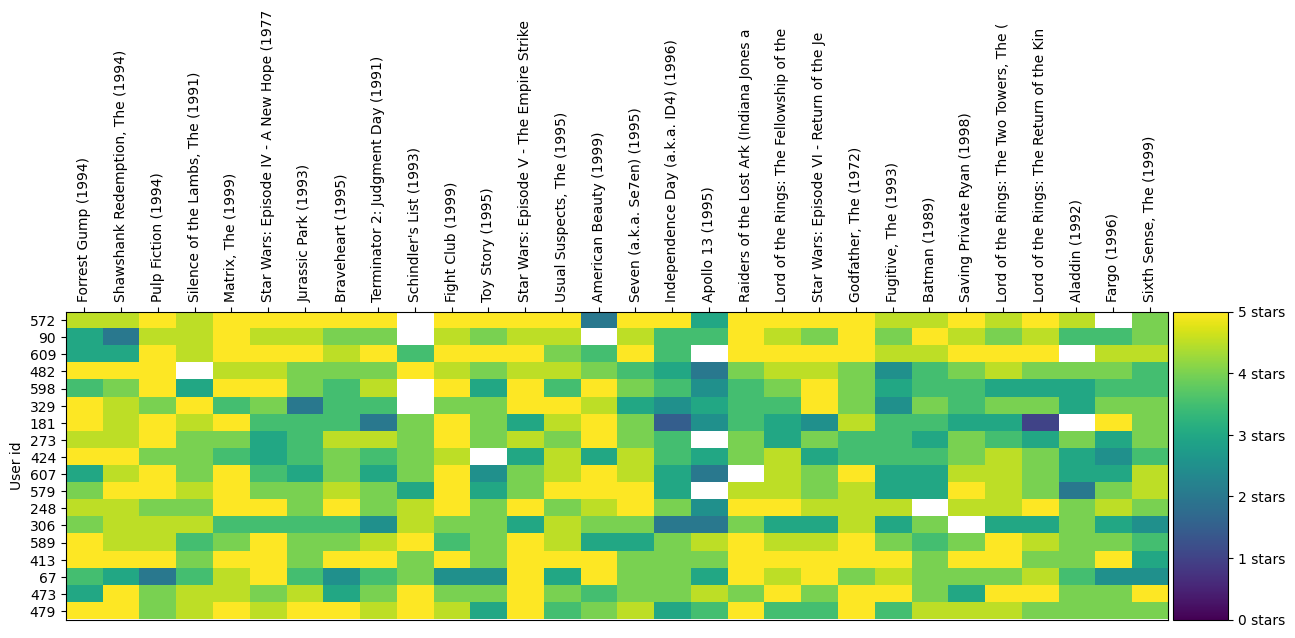

In [21]:
# Define the plotting heatmap function
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):

    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()

    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')
    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    ax.grid(False)
    ax.set_ylabel('User id')# Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)# Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
    plt.show()# Print the heatmap
draw_movies_heatmap(most_rated_movies_users_selection)

In [22]:
# Pivot the dataset and choose the first 1000 movies
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000).replace(np.nan, 0)

In [23]:
from scipy import sparse

# Conversion to sparse csr matrix
sparse_ratings = sparse.csr_matrix(most_rated_movies_1k.values)

### Large Scale Clustering

In [28]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Example function for the most rated movies (must match your context)
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # Count ratings for each movie
    movie_ratings_count = user_movie_ratings.notnull().sum()

    # Sort movies by rating count and select top `max_number_of_movies`
    sorted_movies = user_movie_ratings[movie_ratings_count.index].loc[:, movie_ratings_count.sort_values(ascending=False).index]
    most_rated_movies = sorted_movies.iloc[:, :max_number_of_movies]

    return most_rated_movies

# Sample function to draw movie clusters (Assumes `clustered` DataFrame with clusters assigned)
def draw_movie_clusters(clustered, max_users, max_movies):
    # Assuming clustered dataframe has 'group' and the movie ratings data
    plt.figure(figsize=(10, 8))

    # Create a heatmap to visualize the ratings
    cluster_data = clustered.iloc[:, :max_movies]  # Select up to the top `max_movies`
    cluster_labels = clustered['group']  # Cluster assignments

    # Prepare a pivot table to visualize the ratings per cluster
    pivot_data = cluster_data.T
    pivot_data['cluster'] = cluster_labels
    pivot_data = pivot_data.groupby('cluster').mean()

    # Check if pivot_data is empty and handle the error
    if pivot_data.empty:
        print("Error: The pivot_data is empty. This might indicate missing ratings for the selected cluster and movies.")
        return

    # Create heatmap
    sns.heatmap(pivot_data, cmap='coolwarm', annot=True, fmt='.2f', cbar=True)
    plt.title(f'Movie Clusters for Top {max_users} Users and {max_movies} Movies')
    plt.xlabel('Movie')
    plt.ylabel('Cluster')
    plt.show()

# Clustering using KMeans
predictions = KMeans(n_clusters=20, algorithm='lloyd').fit_predict(sparse_ratings)

# Select the most rated movies (1000 movies)
most_rated_movies = get_most_rated_movies(user_movie_ratings, 1000)

# Create a DataFrame to concatenate user_movie_ratings, KMeans predictions, and cluster information
clustered = pd.concat([most_rated_movies.reset_index(), pd.DataFrame({'group': predictions})], axis=1)

# Draw the heatmap for movie clusters (top users and top movies)
max_users = 50  # Adjust this value for the number of users to display
max_movies = 30  # Adjust this value for the number of movies to display
draw_movie_clusters(clustered, max_users, max_movies)

Error: The pivot_data is empty. This might indicate missing ratings for the selected cluster and movies.


<Figure size 1000x800 with 0 Axes>

### Predictions and Recommendation

     userId  Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
131     132                  4.0                               4.5   
176     177                  5.0                               5.0   
306     307                  4.0                               4.5   
356     357                  3.5                               4.0   
380     381                  4.0                               3.5   
386     387                  4.0                               3.5   
482     483                  5.0                               5.0   
488     489                  4.0                               NaN   
524     525                  4.0                               4.5   
599     600                  4.0                               3.5   
605     606                  4.0                               3.5   

     Pulp Fiction (1994)  Silence of the Lambs, The (1991)  \
131                  4.0                               3.5   
176                  5.0           

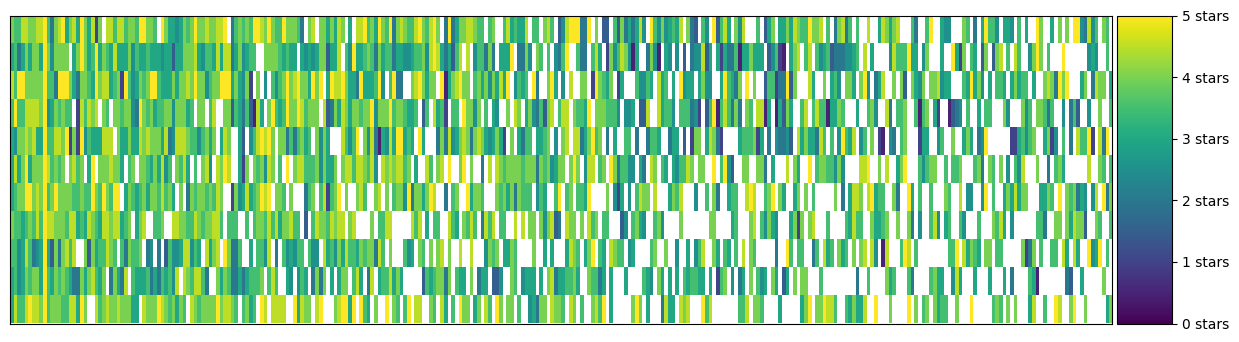

In [30]:
# Pick a cluster ID from the clusters above
cluster_number = 11
# Let's filter to only see the region of the dataset with the most number of values
n_users = 75
n_movies = 300
# The 'index' column likely doesn't exist, drop only the 'group' column
cluster = clustered[clustered.group == cluster_number].drop(['group'], axis=1)
print(cluster)
# Sort and print the cluster
cluster = sort_by_rating_density(cluster, n_movies, n_users)
draw_movies_heatmap(cluster, axis_labels=False)

In [31]:
# Fill in the name of the column/movie. e.g. 'Forrest Gump (1994)'
movie_name = "Matrix, The (1999)"
cluster[movie_name].mean()

4.05

In [32]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

,0
Who Framed Roger Rabbit? (1988),3.409091
When Harry Met Sally... (1989),3.727273
Mrs. Doubtfire (1993),3.363636
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),3.681818
Fight Club (1999),4.363636
"Nightmare Before Christmas, The (1993)",3.954545
Beetlejuice (1988),3.909091
Mary Poppins (1964),4.000000
"Beautiful Mind, A (2001)",3.636364
userId,404.000000


In [33]:
cluster

,Who Framed Roger Rabbit? (1988),When Harry Met Sally... (1989),Mrs. Doubtfire (1993),Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),Fight Club (1999),"Nightmare Before Christmas, The (1993)",Beetlejuice (1988),Mary Poppins (1964),"Beautiful Mind, A (2001)",userId,...,Zoolander (2001),"Jungle Book, The (1967)",Dumbo (1941),Annie Hall (1977),Con Air (1997),"Italian Job, The (2003)",Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964),Hotel Rwanda (2004),Time Bandits (1981),Cast Away (2000)
482,4.0,3.5,3.5,4.5,4.5,4.0,4.0,4.5,4.5,483,...,5.0,2.5,2.0,4.5,2.5,3.5,NaN,4.0,3.5,NaN
306,3.0,3.5,2.0,3.0,4.0,3.0,4.0,4.0,3.0,307,...,NaN,NaN,NaN,2.5,3.0,2.5,NaN,NaN,3.5,NaN
176,4.5,3.5,5.0,5.0,4.0,4.0,4.0,4.0,4.0,177,...,NaN,3.0,4.0,NaN,2.0,4.5,4.0,4.0,NaN,3.0
488,3.5,5.0,3.5,3.5,4.5,4.5,4.5,4.5,4.0,489,...,1.5,NaN,NaN,2.5,NaN,NaN,4.0,NaN,NaN,3.5
599,3.0,2.5,4.0,4.0,4.5,4.0,4.5,3.0,3.0,600,...,4.5,3.5,3.5,5.0,1.0,NaN,4.5,2.0,5.0,NaN
605,3.0,4.5,3.0,4.0,5.0,3.0,4.0,4.0,4.0,606,...,NaN,NaN,NaN,4.5,NaN,NaN,4.0,3.5,NaN,3.5
380,3.0,3.5,4.0,4.0,5.0,5.0,4.0,4.5,4.0,381,...,2.0,3.0,2.5,NaN,2.5,4.5,NaN,5.0,2.0,4.0
524,4.0,3.5,3.5,3.0,3.5,4.0,3.5,4.5,3.5,525,...,4.0,4.0,1.5,NaN,NaN,4.0,3.5,NaN,NaN,3.5
386,3.5,3.5,2.5,3.0,4.5,3.5,2.0,2.5,3.0,387,...,3.0,NaN,NaN,5.0,2.5,3.0,5.0,NaN,3.5,NaN
131,3.0,3.5,2.5,3.0,4.0,3.5,4.0,4.0,3.0,132,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN


In [35]:
# Predict for a specific user

# Pick a user ID from the dataset
# Ensure the user_id exists in the cluster DataFrame index
user_id = cluster.index[0] # Get the first user ID from the index
print(f"Selected user ID: {user_id}")

# Get all this user's ratings
user_2_ratings  = cluster.loc[user_id, :]
# Which movies did they not rate?
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]
# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]
# Let's sort by rating so the highest rated movies are presented first
avg_ratings.sort_values(ascending=False)[:20]

Selected user ID: 482


,0
Donnie Darko (2001),4.500000
"Graduate, The (1967)",4.416667
Little Miss Sunshine (2006),4.200000
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964),4.166667
"Silence of the Lambs, The (1991)",4.166667
Psycho (1960),4.125000
"Shining, The (1980)",4.111111
Children of Men (2006),4.083333
Rain Man (1988),4.071429
Requiem for a Dream (2000),4.000000


## Using Collaborative Filtering (With fast.ai)

In [36]:
! [ -e /content ] && pip install -Uqq fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.5 MB/s eta 0:00:00


In [37]:
from fastai.tabular.all import *
from fastai.collab import *

### Training a model

For this, we will use the [Movielens 100k data dataset](https://grouplens.org/datasets/movielens/100k/). We can download it easily and decompress it with the following function:

In [38]:
path = untar_data(URLs.ML_100k)

The main table is in `u.data`. Since it's not a proper csv, we have to specify a few things while opening it: the tab delimiter, the columns we want to keep and their names.

In [39]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


Movie ids are not ideal to look at things, so we load the corresponding movie id to the title that is in the table `u.item`:

In [41]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Next we merge it to our ratings table:

In [42]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])

We can then build a `DataLoaders` object from this table. By default, it takes the first column for user, the second column for the item (here our movies) and the third column for the ratings. We need to change the value of `item_name` in our case, to use the titles instead of the ids:

In [45]:
# Merge ratings and movies DataFrames on the 'movie' column
ratings = pd.merge(ratings, movies, on='movie')

# Now create the CollabDataLoaders object
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)


In all applications, when the data has been assembled in a `DataLoaders`, you can have a look at it with the `show_batch` method:

In [46]:
dls.show_batch()

,user,title,rating
0,839,Gridlock'd (1997),4
1,59,"American President, The (1995)",3
2,311,One Flew Over the Cuckoo's Nest (1975),5
3,710,Return of the Jedi (1983),3
4,535,Three Colors: Red (1994),3
5,128,Fried Green Tomatoes (1991),2
6,95,E.T. the Extra-Terrestrial (1982),5
7,184,Alien (1979),4
8,178,Fly Away Home (1996),4
9,857,Angels and Insects (1995),3


fastai can create and train a collaborative filtering model by using `collab_learner`:

In [47]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

It uses a simple dot product model with 50 latent factors. To train it using the 1cycle policy, we just run this command:

In [48]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.871271,0.957672,00:08
1,0.680373,0.900841,00:07
2,0.525914,0.888043,00:08
3,0.456893,0.868427,00:08
4,0.424619,0.863373,00:07


Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91 (scroll down to the 100k dataset), which corresponds to an MSE of `0.91**2 = 0.83`. So in less than a minute, we got pretty good results!

### Interpretation

Let's analyze the results of our previous model. We will keep the 1000 most rated movies for this:

In [49]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

### Movie bias

Our model has learned one bias per movie, a unique number independent of users that can be interpreted as the intrinsic "value" of the movie. We can grab the bias of each movie in our `top_movies` list with the following command:

In [50]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

Let's compare those biases with the average ratings:

In [51]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

Now let's have a look at the movies with the worst bias:

In [52]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3468),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3224),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2692), 'Thinner (1996)', 2.4489795918367347),
 (tensor(-0.2614), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2497), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2492), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2411), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2408), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2393), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2341), 'Kansas City (1996)', 2.260869565217391),
 (tensor(-0.2336), 'Halloween: The Curse of Michael Myers (1995)', 2.2),
 (tensor(-0.2312), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2205), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2171), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(

Or the ones with the best bias:

In [53]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5696), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5568), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5531), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5385), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5307), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5237), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5082), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.4949), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4794), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4793), 'Wrong Trousers, The (1993)', 4.466101694915254),
 (tensor(0.4748), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4727), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4707), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4626),
  'Wallace & Gromit: The Best of Aardman Animation (1996)',
  4.447761194029851),
 (tensor(0.4583), 'Apt Pupil (1998)', 4.1)]

There is certainly a strong correlation!

### Movie weights

Now let's try to analyze the latent factors our model has learned. We can grab the weights for each movie in `top_movies` the same way as we did for the bias before.

In [54]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

Let's try a PCA to reduce the dimensions and see if we can see what the model learned:

In [55]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [56]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

Here are the highest score on the first dimension:

In [57]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.2236), "McHale's Navy (1997)"),
 (tensor(1.1933), 'Children of the Corn: The Gathering (1996)'),
 (tensor(1.1838), 'Jungle2Jungle (1997)'),
 (tensor(1.1565), 'Bio-Dome (1996)'),
 (tensor(1.1171), 'Leave It to Beaver (1997)'),
 (tensor(1.1068), 'Free Willy 3: The Rescue (1997)'),
 (tensor(1.0638), 'Mortal Kombat: Annihilation (1997)'),
 (tensor(1.0545), 'D3: The Mighty Ducks (1996)'),
 (tensor(1.0415), 'Flintstones, The (1994)'),
 (tensor(1.0137), 'Wishmaster (1997)')]

And the worst:

In [58]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1836), 'Casablanca (1942)'),
 (tensor(-1.1421), 'Godfather, The (1972)'),
 (tensor(-1.0873), 'Some Folks Call It a Sling Blade (1993)'),
 (tensor(-1.0831), 'Chinatown (1974)'),
 (tensor(-1.0092), 'Citizen Kane (1941)'),
 (tensor(-1.0089),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(-0.9845), 'Wallace & Gromit: The Best of Aardman Animation (1996)'),
 (tensor(-0.9823), 'Third Man, The (1949)'),
 (tensor(-0.9740), 'Lawrence of Arabia (1962)'),
 (tensor(-0.9723), 'Fargo (1996)')]

Same thing for our second dimension:

In [59]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [60]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.8028), 'Lost Highway (1997)'),
 (tensor(0.7951), 'Jude (1996)'),
 (tensor(0.7933), 'Brazil (1985)'),
 (tensor(0.7905), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(0.7811), 'Dracula: Dead and Loving It (1995)'),
 (tensor(0.7615), 'Stuart Saves His Family (1995)'),
 (tensor(0.7450), 'Exotica (1994)'),
 (tensor(0.7410), 'Boogie Nights (1997)'),
 (tensor(0.7337), 'To Die For (1995)'),
 (tensor(0.7287), 'Trainspotting (1996)')]

In [61]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1267), 'Braveheart (1995)'),
 (tensor(-1.1217), 'Titanic (1997)'),
 (tensor(-0.9911), 'Raiders of the Lost Ark (1981)'),
 (tensor(-0.9477), 'Independence Day (ID4) (1996)'),
 (tensor(-0.8763), 'Top Gun (1986)'),
 (tensor(-0.8703), 'While You Were Sleeping (1995)'),
 (tensor(-0.8474), 'Back to the Future (1985)'),
 (tensor(-0.8451), 'Air Force One (1997)'),
 (tensor(-0.8398), 'Forrest Gump (1994)'),
 (tensor(-0.8270), 'Indiana Jones and the Last Crusade (1989)')]

And we can even plot the movies according to their scores on those dimensions:

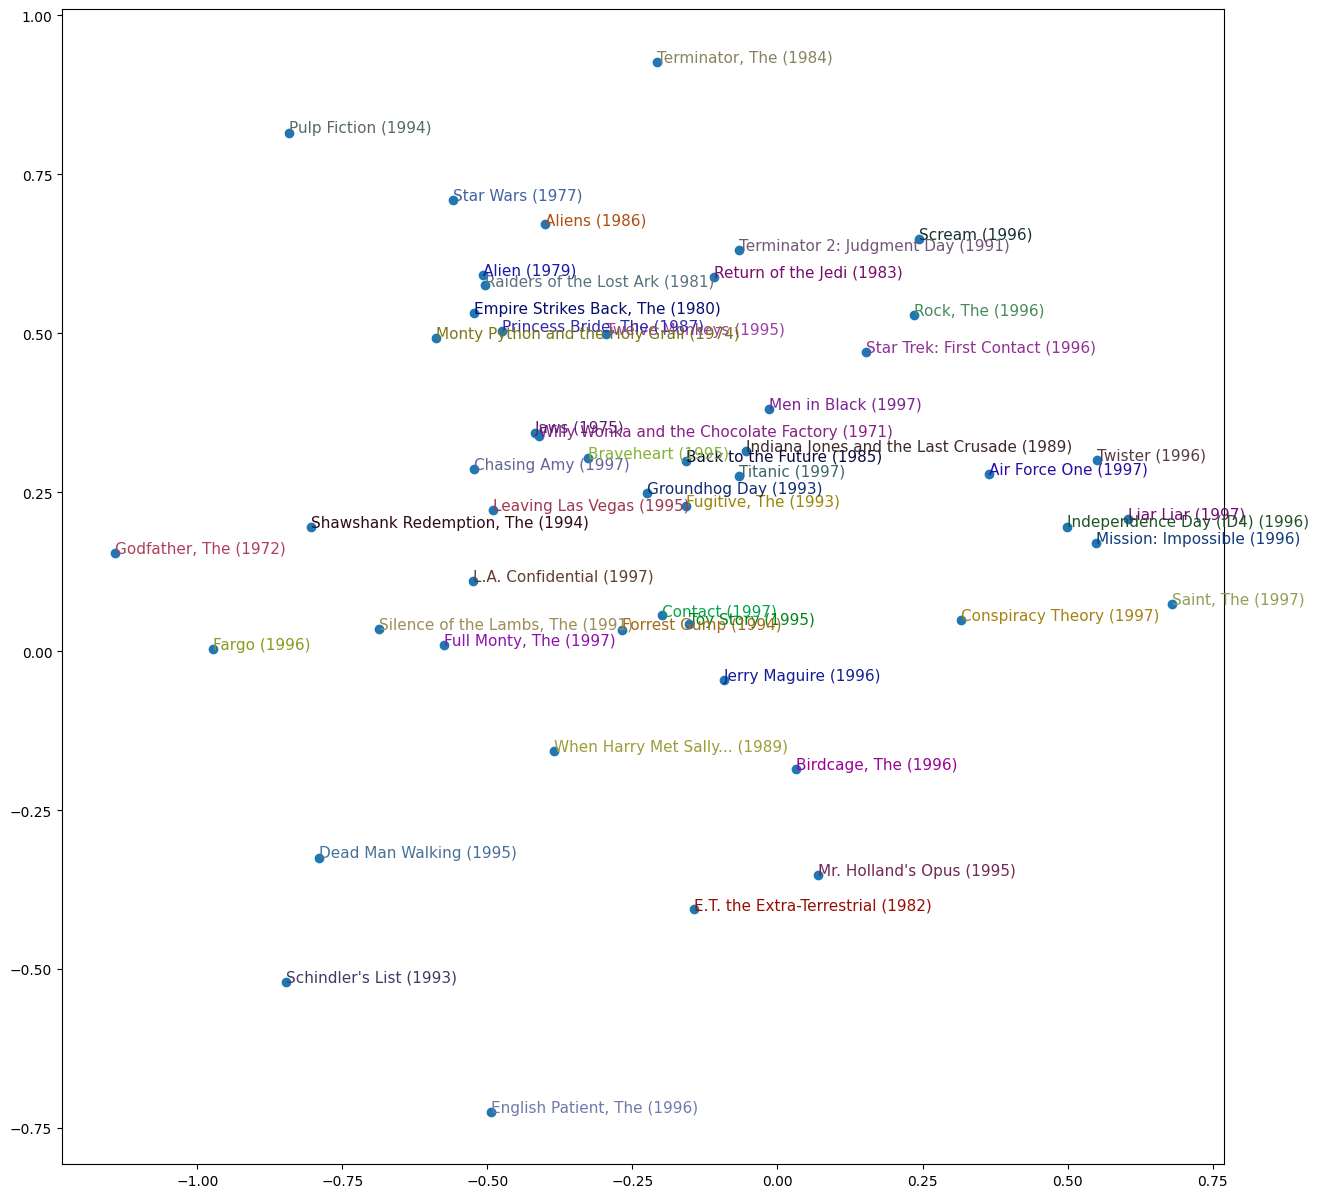

In [62]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# Exercise 2

## Play around with different collaborative filtering model parameters such as n_factors and other parameters.
Collaborative filtering (CF) is widely used for recommendation systems. When experimenting with collaborative filtering models, there are multiple parameters to tune for better performance. If you are using matrix factorization (e.g., Singular Value Decomposition (SVD) or Alternating Least Squares (ALS)), one of the most critical parameters to adjust is n_factors, which determines the number of latent factors to use in the model.

To play around with collaborative filtering, you can use libraries like Surprise (for SVD, SVD++, KNN-based CF, etc.) or implicit (for ALS).

Here's how you can try out different parameters with Surprise and implicit:

1. Using Surprise for Collaborative Filtering:
The Surprise library is a great choice for easy implementation of collaborative filtering. It allows you to experiment with different models like SVD, KNN, and others, and tune parameters like n_factors, learning_rate, and epochs.

python
Copy
Edit
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

# Load the dataset
# Assuming you have a dataset 'user_movie_ratings' with 'user_id', 'movie_id', and 'rating'
reader = Reader(rating_scale=(1, 5))  # Adjust rating scale accordingly
data = Dataset.load_from_df(user_movie_ratings[['user_id', 'movie_id', 'rating']], reader)

# Split the dataset into training and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Try different values for n_factors, n_epochs, and learning_rate
svd = SVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02)

# Train the model
svd.fit(trainset)

# Test the model
predictions = svd.test(testset)

# Evaluate performance
rmse = accuracy.rmse(predictions)
print(f'RMSE for SVD with n_factors=50, n_epochs=20: {rmse}')
Experimenting with Different Parameters:
You can experiment with the following parameters in the SVD model:

n_factors: The number of latent factors (dimensions). Higher values may lead to better predictions but also overfitting.
n_epochs: The number of iterations for training. A higher number allows the model to learn better, but too many can lead to overfitting.
lr_all: Learning rate for all parameters.
reg_all: Regularization term. Adjust this to control overfitting.
2. Using implicit for Alternating Least Squares (ALS):
The implicit library is designed for matrix factorization techniques like ALS and works well with sparse matrices.

python
Copy
Edit
import implicit
import numpy as np
from scipy.sparse import coo_matrix

# Assuming 'user_movie_ratings' has columns 'user_id', 'movie_id', 'rating'
# Convert ratings to a sparse matrix format
user_movie_ratings['rating'] = user_movie_ratings['rating'].astype(float)
ratings_matrix = coo_matrix((user_movie_ratings['rating'],
                             (user_movie_ratings['user_id'], user_movie_ratings['movie_id'])))

# Initialize the ALS model
model = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.1, iterations=30)

# Fit the model on the sparse ratings matrix
model.fit(ratings_matrix)

# Get recommendations for a user (for example, user_id 1)
recommendations = model.recommend(1, ratings_matrix[1], N=10)  # top 10 recommendations
print("Recommendations for user 1:", recommendations)
Experimenting with Different Parameters for ALS:
factors: The number of latent factors (similar to n_factors in SVD). Try different values such as 50, 100, 200 to see their impact on performance.
regularization: Regularization parameter to avoid overfitting. You can adjust this to 0.01, 0.1, or higher based on the data.
iterations: The number of iterations ALS will run. Higher values may lead to better models, but also increase computation time.
3. Evaluating Performance:
You can evaluate the collaborative filtering models using metrics like RMSE (Root Mean Squared Error) for SVD or Mean Average Precision (MAP) for top-N recommendations.
Here’s how you could compute RMSE for ALS or SVD:

python
Copy
Edit
from sklearn.metrics import mean_squared_error
import numpy as np

# For SVD
predictions = svd.test(testset)
rmse = accuracy.rmse(predictions)
print(f'RMSE for SVD: {rmse}')

# For ALS, compare the predicted ratings with true ratings
predicted_ratings = model.recommend(user_ids, ratings_matrix, N=10)
# Assuming you have true ratings to compare
mse = mean_squared_error(true_ratings, predicted_ratings)
rmse = np.sqrt(mse)
print(f'RMSE for ALS: {rmse}')
4. Cross-Validation:
For better results, you can cross-validate the models by splitting the data into multiple folds and evaluating the performance across them:

python
Copy
Edit
from surprise.model_selection import cross_validate

# Cross-validate the SVD model with different parameters
cross_validate(SVD(n_factors=50, n_epochs=20), data, measures=['RMSE'], cv=3, verbose=True)
Things to Experiment with:
n_factors: Try values like 10, 50, 100 to observe how the number of latent factors impacts performance. Too few factors might not capture enough complexity, and too many might lead to overfitting.
Regularization Parameters: Fine-tune regularization terms to balance bias and variance.
Learning Rates and Epochs: Adjust the learning rate and number of epochs to achieve a balance between learning speed and model performance.
Matrix Sparsity: If your data is sparse (many missing values), you can experiment with sparse matrix representations, such as using the coo_matrix in implicit.
By experimenting with these parameters, you should be able to find a configuration that performs well for your collaborative filtering task.

Let me know if you'd like more details on any of these steps!













## Identify if any such parameters have impact on the speed of convergence or the performance on the model
When tuning collaborative filtering models, several parameters impact both the speed of convergence (how quickly the model learns) and the performance (how well the model generalizes to unseen data). Let’s go through the key parameters and their potential impacts:

1. Number of Latent Factors (n_factors or factors):
Impact on Convergence Speed:
A higher number of latent factors means the model will have more dimensions to learn, which generally slows down convergence because the optimization process needs to fit more parameters.
Smaller values of n_factors (e.g., 10 or 20) tend to converge faster but might lead to underfitting since fewer factors could capture insufficient underlying patterns in the data.
Impact on Performance:
If n_factors is too small, the model may underfit, as it cannot capture complex relationships in the data.
Too large a value may cause overfitting, as it could model noise in the data instead of general patterns.
Optimal value: Usually between 20 and 100, depending on the data’s complexity.
2. Number of Iterations (n_epochs or iterations):
Impact on Convergence Speed:
The number of iterations defines how many times the model will iterate over the training data to adjust the latent factors.
More iterations increase convergence time because the algorithm will perform more updates.
Early stopping can be used to detect when the model starts to overfit and stop training earlier.
Impact on Performance:
Too few iterations might lead to underfitting as the model might not have enough time to learn the data’s patterns.
Too many iterations can lead to overfitting as the model starts to learn noise in the data rather than true patterns.
Optimal value: Usually between 10 and 100 epochs.
3. Learning Rate (lr_all or learning_rate):
Impact on Convergence Speed:
A high learning rate allows the model to converge faster initially, but it can also cause the model to overshoot the optimal parameters and result in instability.
A low learning rate makes the model converge slowly, but it can result in more stable and precise optimization.
Impact on Performance:
Too high a learning rate can result in divergence (model fails to converge) or poor generalization because the model might not settle at the optimal solution.
Too low a learning rate leads to slower convergence and can result in underfitting if the model doesn't converge within a reasonable time.
Optimal value: Typically, values around 0.001 to 0.1 work well. It’s often beneficial to try a range of values.
4. Regularization Parameter (reg_all or regularization):
Impact on Convergence Speed:
Stronger regularization (higher values) makes the optimization process slower because it enforces stricter constraints during training.
Weaker regularization (lower values) may speed up convergence but might not sufficiently control overfitting.
Impact on Performance:
Strong regularization can help prevent overfitting but might lead to underfitting if too much penalty is applied.
Weak regularization can overfit the model, making it highly sensitive to noise in the training data.
Optimal value: Values between 0.01 and 0.1 are often a good starting point.
5. Batch Size (only for some algorithms, like ALS):
Impact on Convergence Speed:
Smaller batch sizes can result in more frequent updates and may lead to faster convergence, but the model may experience more noise during training.
Larger batch sizes tend to result in more stable updates, but convergence may be slower.
Impact on Performance:
Small batches may lead to faster training but result in noisy convergence, potentially leading to worse performance.
Large batches provide more stable convergence but may require more computation and slower convergence.
6. Number of Neighbors (n_neighbors for KNN-based CF):
Impact on Convergence Speed:
KNN-based methods often involve computing similarity between users or items. The number of neighbors (n_neighbors) impacts the speed of the algorithm because larger values require more similarity comparisons.
Smaller n_neighbors speeds up the computation, but could be less accurate in terms of finding meaningful relationships.
Larger n_neighbors may increase accuracy but slow down convergence because the model has to consider more neighbors for each user/item.
Impact on Performance:
Too few neighbors might cause overfitting (high variance).
Too many neighbors could result in underfitting (high bias).
Optimal value: Usually ranges from 5 to 50.
7. Matrix Sparsity (handling missing values):
Impact on Convergence Speed:
Sparse matrices (with many missing values) can slow down convergence because algorithms need to handle missing values carefully.
Efficient handling of missing values (e.g., using sparse representations) helps speed up convergence and memory usage.
Impact on Performance:
Handling missing values properly is crucial for good performance. If missing data is ignored or poorly handled, it can significantly degrade model quality.
Optimal value: Use sparse representations like scipy.sparse for better performance on large datasets.
Key Observations:
Higher n_factors and more iterations lead to slower convergence but might improve performance, up to a point where the model overfits.
Learning rate and regularization balance convergence speed and model generalization:
A higher learning rate speeds up convergence but risks instability.
Stronger regularization slows down convergence but improves generalization by reducing overfitting.
Performance and Convergence are often at odds: faster convergence might not lead to the best model. Slower convergence (e.g., low learning rate, higher regularization) often improves model performance by avoiding overfitting.
Recommendations for Faster Convergence with Optimal Performance:
Start with reasonable defaults like n_factors=20 to 50, n_epochs=10 to 30, and a moderate learning rate (e.g., 0.005).
Tune regularization: Start with a small regularization value and increase if you observe overfitting.
Use early stopping to halt training once the model’s performance stops improving on a validation set.
Evaluate on a validation set: Use cross-validation to ensure that any changes in convergence speed do not negatively impact the performance.
Batch size and matrix sparsity: If using algorithms like ALS, experiment with batch sizes and ensure sparse data is handled efficiently.
By adjusting these parameters, you can strike a balance between faster convergence and better performance. Regularly evaluating your model using metrics like RMSE or Precision at K is crucial to ensure that you're achieving optimal results.

In [ ]:
# CODE